# Introduction

In [ ]:
"""
What? Ensemble for classifier chain

Reference: https://scikit-learn.org/stable/auto_examples/multioutput/plot_classifier_chain_yeast.html#sphx-glr-auto-examples-multioutput-plot-classifier-chain-yeast-py
"""

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression

# Import dataset

In [ ]:
"""
For this example we will use the yeast dataset which contains 2417 datapoints each with 103 features and 14 
possible labels. Each data point has at least one label. 
"""

In [2]:
# Load a multi-label dataset from https://www.openml.org/d/40597
X, Y = fetch_openml('yeast', version=4, return_X_y=True)
Y = Y == 'TRUE'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2,
                                                    random_state=0)

# Fit single model

In [ ]:
"""
As a baseline we first train a logistic regression classifier for each of the 14 labels. To evaluate the 
performance of these classifiers we predict on a held-out test set and calculate the jaccard score for each sample.
"""

In [4]:
# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
base_lr = LogisticRegression()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average='samples')

# Create ensemble model

In [ ]:
"""
Next we create 10 classifier chains. Each classifier chain contains a logistic regression model for each of the
14 labels. The models in each chain are ordered randomly. In addition to the 103 features in the dataset, each
model gets the predictions of the preceding models in the chain as features (note that by default at training 
time each model gets the true labels as features). These additional features allow each chain to exploit 
correlations among the classes. The Jaccard similarity score for each chain tends to be greater than that 
of the set independent logistic models.
"""

In [5]:
# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])
chain_jaccard_scores = [jaccard_score(Y_test, Y_pred_chain >= .5,
                                      average='samples')
                        for Y_pred_chain in Y_pred_chains]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(Y_test,
                                       Y_pred_ensemble >= .5,
                                       average='samples')

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = ('Independent',
               'Chain 1',
               'Chain 2',
               'Chain 3',
               'Chain 4',
               'Chain 5',
               'Chain 6',
               'Chain 7',
               'Chain 8',
               'Chain 9',
               'Chain 10',
               'Ensemble')

x_pos = np.arange(len(model_names))

# Plotting

In [ ]:
"""
Plot the Jaccard similarity scores for the independent model, each of the
chains, and the ensemble (note that the vertical axis on this plot does
not begin at 0).
"""

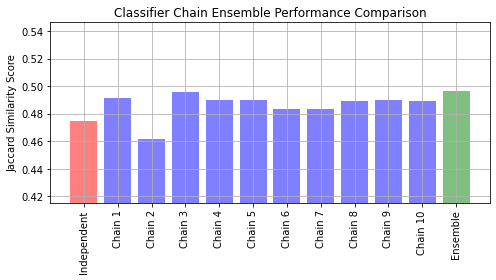

In [6]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()